Final SHI GPR Modelling
Python 3.12.4

In [121]:
import os
import time
from pathlib import Path
import numpy as np
import pickle
import matplotlib.animation as manimation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct
from numpy import interp
import sqlite3
import json

In [102]:
startFrame = 112
endFrame = 200
file = r"C:\Users\paoli\Downloads\level1.mp4"
samples = 32
steps = 1001


In [34]:
path = 'G:\\My Drive\\SHI\\2024' 
os.chdir(path)
objects = []
# step  level j  i  w  h  dx 
# 0     1     2  3  4  5  6 
with (open("patches.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
a = objects[0]
print(f"Box database: {a.shape}")

Box database: (22624, 7)


h: 0.00390625
mesh: 129,257
Z dim: (1001, 129, 257)
ZZ dim: (129, 257)


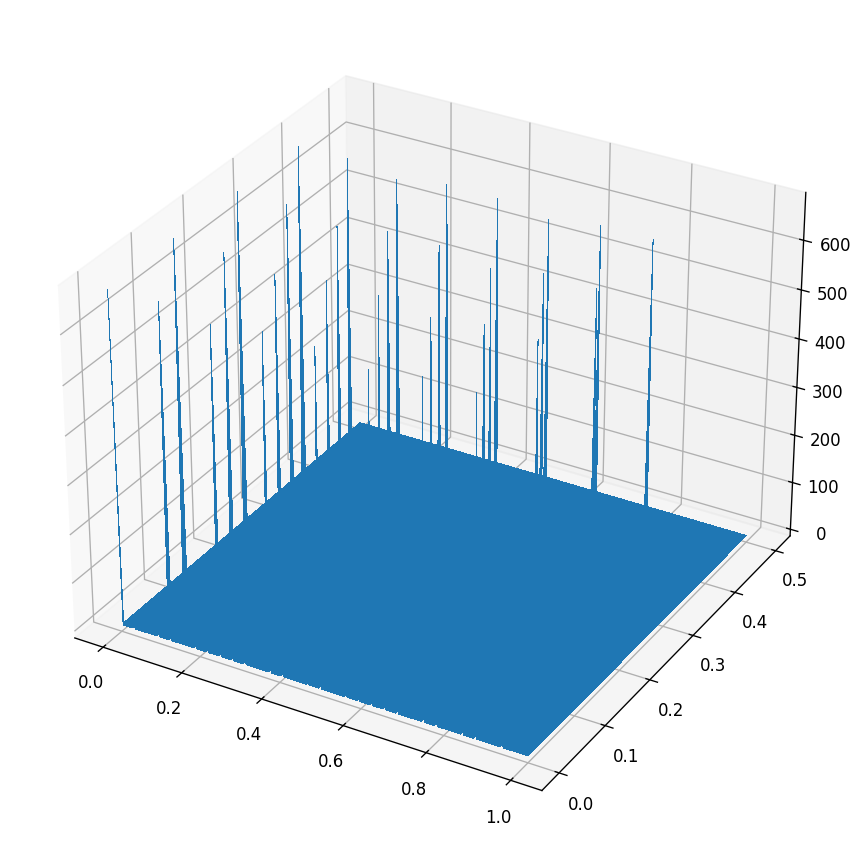

In [35]:
x_min = 0.0 
x_max = 1.0
y_min = 0.0 
y_max = 0.5
coarseFactor = 1
factor = 1
h = 0
for box in range(a.shape[0]):
    if int(a[box,1]) == 1:   # level 1 box
        if h == 0:
            h = a[box,6]
            print(f'h: {h}')
            xx, yy = np.meshgrid(np.arange(x_min, x_max+h, coarseFactor*h), np.arange(y_min, y_max+h, coarseFactor*h))
            rows = xx.shape[0]
            cols = xx.shape[1]
            print(f'mesh: {rows},{cols}')
            Z = np.zeros((steps,rows,cols))
        # step  level i  j  w  h  dx    
        # 0     1     2  3  4  5  6 
        Z[int(a[box,0]),int(a[box,3]),int(a[box,2])] += 1

print(f'Z dim: {Z.shape}')
ZZ = np.sum(Z, axis=0)
print(f'ZZ dim: {ZZ.shape}')
X = np.linspace(start=0, stop=1001, num=1001).reshape(-1, 1)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(16*factor, 9*factor), dpi=(1920/16))
surf = ax.plot_surface(xx, yy,  ZZ, rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False)
plt.show()

In [104]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(steps), size=samples, replace=False)
X_train = X[training_indices]

In [107]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import DotProduct,WhiteKernel,Matern,ExpSineSquared
from sklearn.linear_model import LogisticRegression

#kernel = C(0.1, (1e-5, np.inf)) * DotProduct(sigma_0=0.1) ** 2 
#kernel =  LogisticRegression(random_state=0)* DotProduct(sigma_0=0.1) ** 2
#kernel =  DotProduct(sigma_0=0.001, sigma_0_bounds=(1e-15, 1e15))  
#kernelName = 'DotProduct'
#kernel = WhiteKernel(noise_level=0.5)
#kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-7, 1e7))
#kernelName = 'RBF'
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-05, 1e8), nu=0.8)
#kernelName = 'Matern'
kernel = ExpSineSquared(length_scale=0.5, periodicity=1.0, length_scale_bounds=(1e-07, 1e+07), periodicity_bounds=(1e-06, 1e+06))
kernelName = 'ExpSineSquared'
GPdict = {}
mu = {}
sigma = {}
for j in range(cols):
    for i in range(rows):
        if np.sum(Z[:,i,j], axis=0) != 0:
            y_train = Z[training_indices,i,j] 
            print(f'GP fit on grid point {i,j}')
            GPdict[i,j] = GaussianProcessRegressor(kernel=kernel, alpha=1e-3)
            #params_rbf = {'k1__constant_value_bounds':(1e-07, 1e+07)}
            #GPdict[i,j].set_params(**params_rbf)
            GPdict[i,j].fit(X_train, y_train)
            print(GPdict[i,j].kernel_.get_params())
            mu[i,j], sigma[i,j] = GPdict[i,j].predict(X, return_std=True)
            #gaussian_process.kernel_
        #else:
            #print(f'Exclude grid point {i,j}')

GP fit on grid point (0, 0)
{'length_scale': 0.5, 'periodicity': 1.0, 'length_scale_bounds': (1e-07, 10000000.0), 'periodicity_bounds': (1e-06, 1000000.0)}
GP fit on grid point (32, 0)
{'length_scale': 0.5, 'periodicity': 1.0, 'length_scale_bounds': (1e-07, 10000000.0), 'periodicity_bounds': (1e-06, 1000000.0)}
GP fit on grid point (64, 0)
{'length_scale': 0.5, 'periodicity': 1.0, 'length_scale_bounds': (1e-07, 10000000.0), 'periodicity_bounds': (1e-06, 1000000.0)}
GP fit on grid point (96, 0)
{'length_scale': 0.5, 'periodicity': 1.0, 'length_scale_bounds': (1e-07, 10000000.0), 'periodicity_bounds': (1e-06, 1000000.0)}
GP fit on grid point (0, 8)
{'length_scale': 0.5, 'periodicity': 1.0, 'length_scale_bounds': (1e-07, 10000000.0), 'periodicity_bounds': (1e-06, 1000000.0)}
GP fit on grid point (32, 8)
{'length_scale': 0.5, 'periodicity': 1.0, 'length_scale_bounds': (1e-07, 10000000.0), 'periodicity_bounds': (1e-06, 1000000.0)}
GP fit on grid point (64, 8)
{'length_scale': 0.5, 'periodic

In [140]:
db_file = r"C:\Users\paoli\Documents\gprmesh.db"    # will not work if .db file is in a Google drive path
path = Path(db_file)
if path.is_file():
    print(f'removing {db_file}')
    try:
        os.remove(db_file)
    except:
        print("cannot remove file {db_file}")

connection = sqlite3.connect(db_file)
create_table_query = '''CREATE TABLE level1_gpr_mesh 
    (i INTEGER,
    j INTEGER, 
    mu JSON,
    sigma JSON);'''
cursor = connection.cursor()
cursor.execute(create_table_query)
connection.commit()
connection.close()

In [143]:
connection = sqlite3.connect(db_file)
insert_query = '''
    INSERT INTO level1_gpr_mesh (i, j, mu, sigma)
    VALUES (?, ?, ?, ?)'''
for j in range(cols):
    for i in range(rows):
        if (i,j) in mu:
            connection.execute(insert_query, (i, j, json.dumps(mu[i,j].tolist()), json.dumps(sigma[i,j].tolist())))
connection.commit()
connection.close()

In [38]:
def colfunc(val, minval, maxval, startcolor, stopcolor):
    """ Convert value in the range minval...maxval to a color in the range
        startcolor to stopcolor. The colors passed and the one returned are
        composed of a sequence of N component values (e.g. RGB).
    """
    f = float(val-minval) / (maxval-minval)
    return tuple(f*(b-a)+a for (a, b) in zip(startcolor, stopcolor))
RED, YELLOW, GREEN  = (1, 0, 0), (1, 1, 0), (0, 1, 0)
CYAN, BLUE, MAGENTA = (0, 1, 1), (0, 0, 1), (1, 0, 1)
steps = 10
minval, maxval = 0.0, 1.0

wrote step 112
wrote step 113
wrote step 114
wrote step 115
wrote step 116
wrote step 117
wrote step 118
wrote step 119
wrote step 120
wrote step 121
wrote step 122
wrote step 123
wrote step 124
wrote step 125
wrote step 126
wrote step 127
wrote step 128
wrote step 129
wrote step 130
wrote step 131
wrote step 132
wrote step 133
wrote step 134
wrote step 135
wrote step 136
wrote step 137
wrote step 138
wrote step 139
wrote step 140
wrote step 141
wrote step 142
wrote step 143
wrote step 144
wrote step 145
wrote step 146
wrote step 147
wrote step 148
wrote step 149
wrote step 150
wrote step 151
wrote step 152
wrote step 153
wrote step 154
wrote step 155
wrote step 156
wrote step 157
wrote step 158
wrote step 159
wrote step 160
wrote step 161
wrote step 162
wrote step 163
wrote step 164
wrote step 165
wrote step 166
wrote step 167
wrote step 168
wrote step 169
wrote step 170
wrote step 171
wrote step 172
wrote step 173
wrote step 174
wrote step 175
wrote step 176
wrote step 177
wrote step

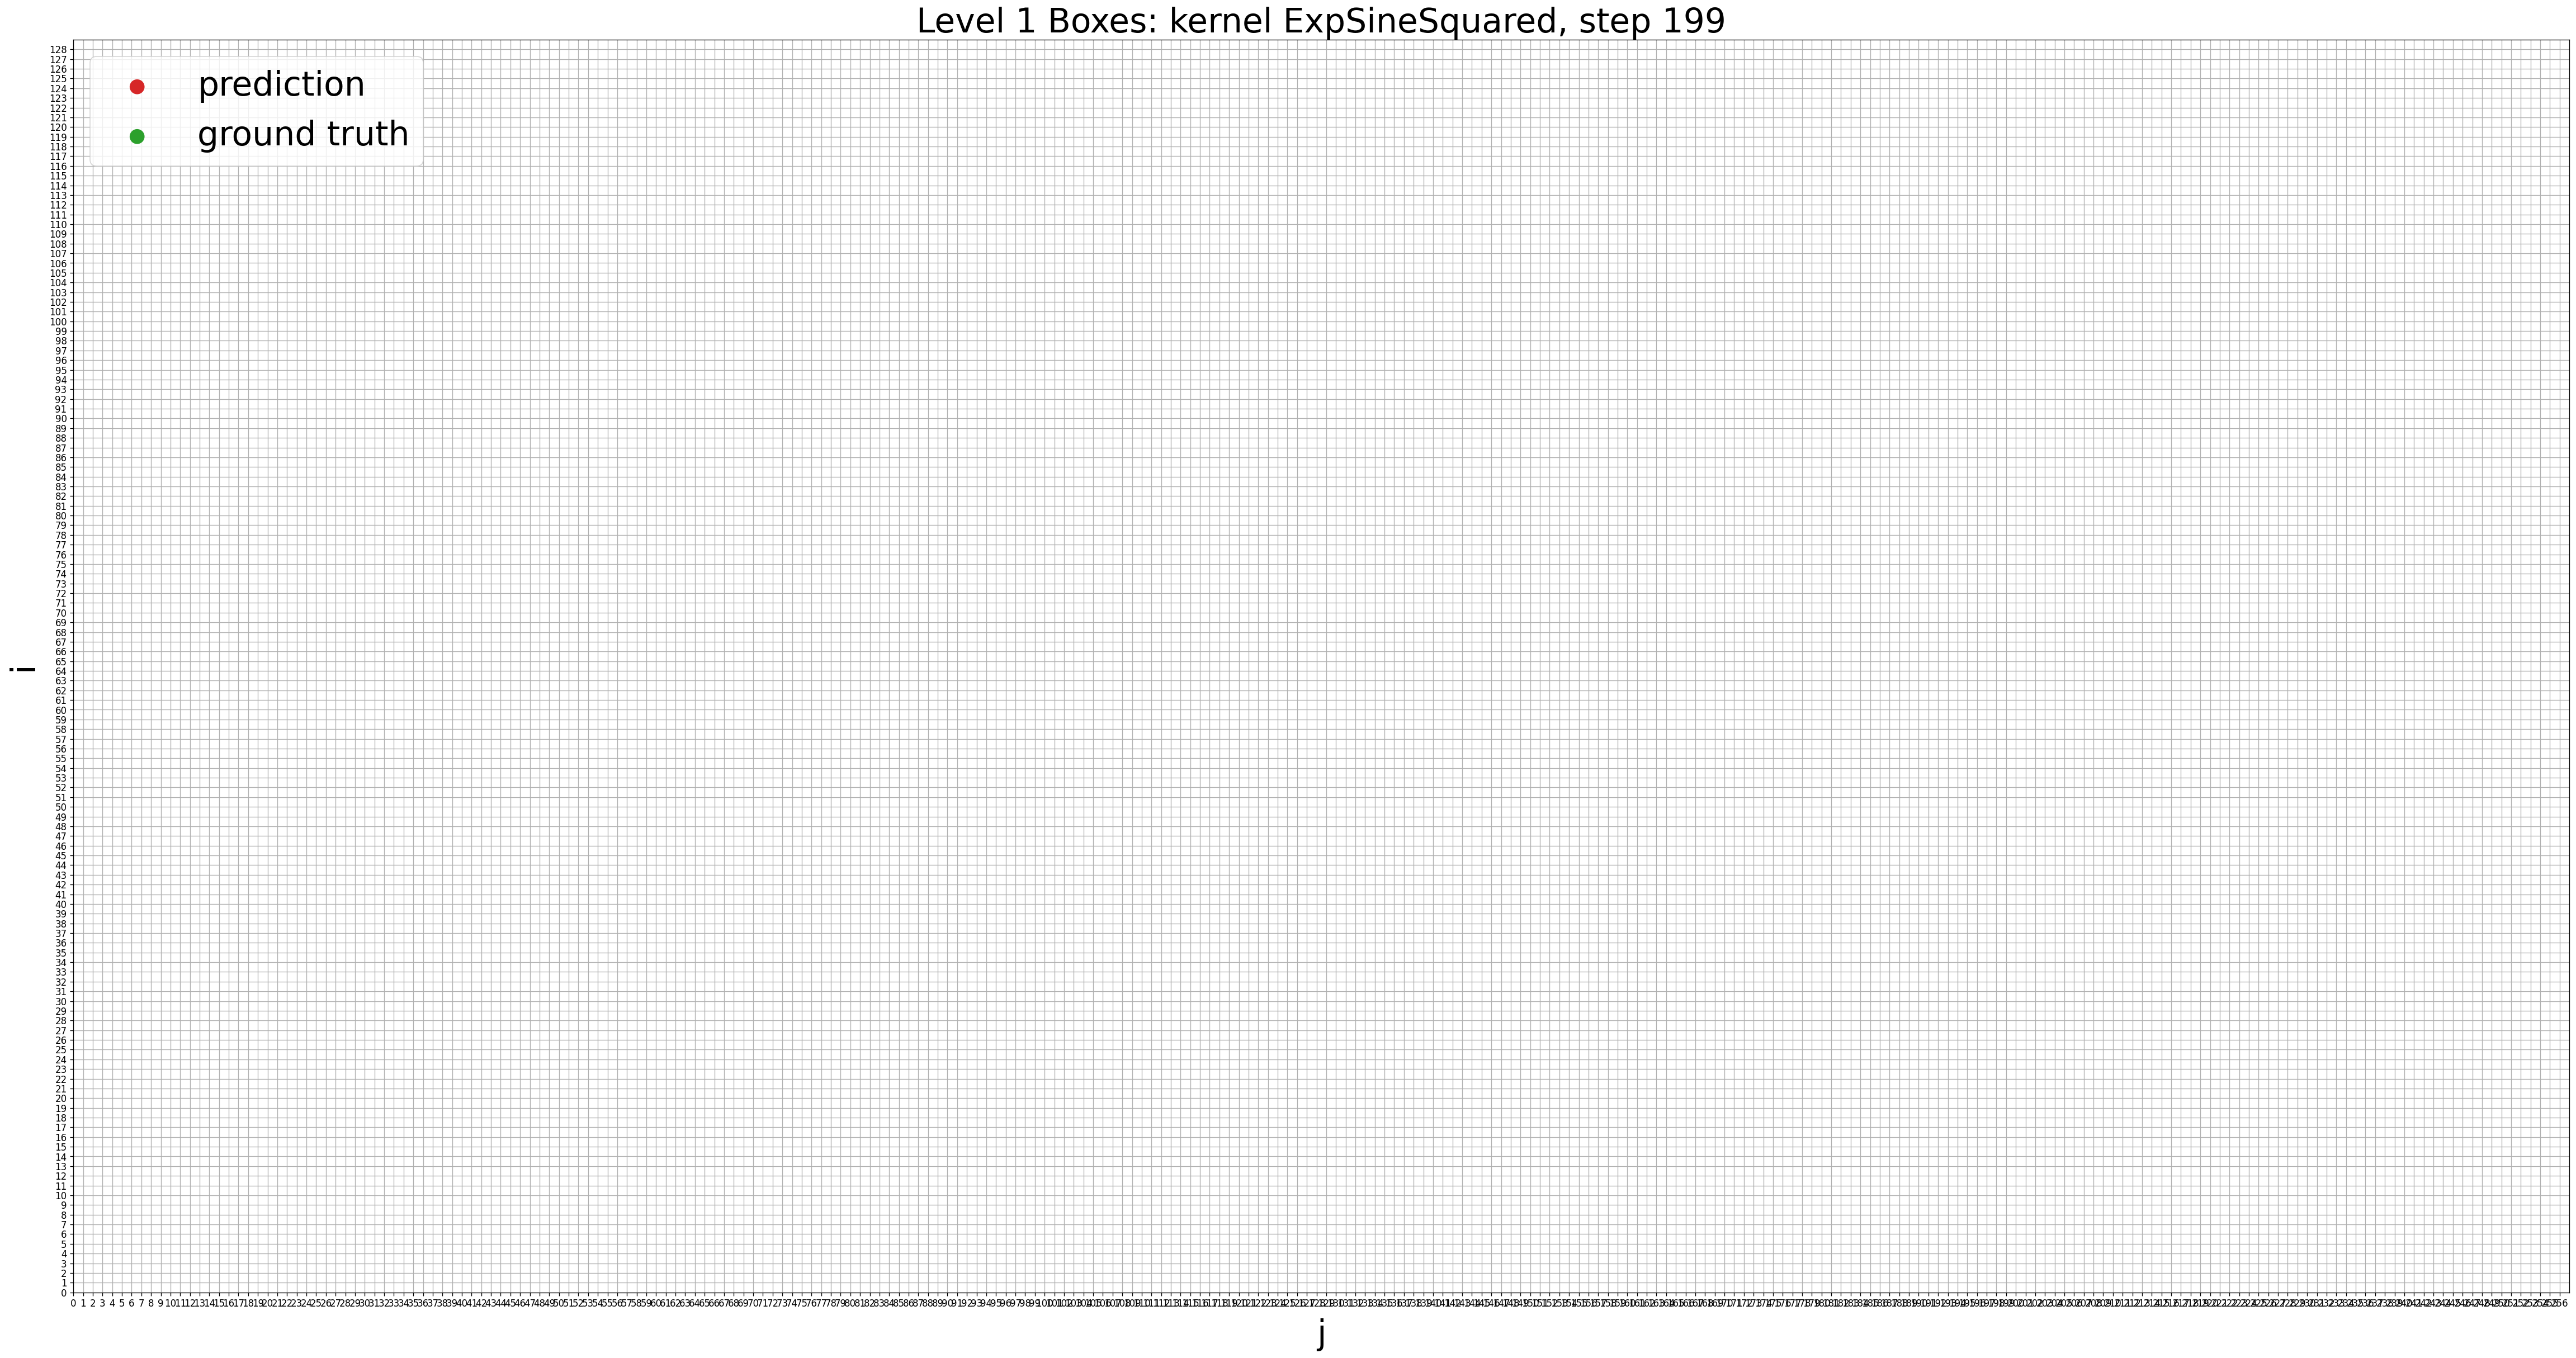

In [108]:
path = Path(file)
if path.is_file():
    os.remove(file)
FFMpegWriter = manimation.writers["ffmpeg"]
metadata = dict(title="Level 1 Boxes", artist="Matplotlib", comment="AMR Testcase")
writer = FFMpegWriter(fps=4,metadata=metadata)
factor = 3
fig = plt.figure(figsize=(16*factor, 9*factor), dpi=(1920/16)) #  120 DPI
#fig = plt.figure(figsize=(16*factor, 9*factor), dpi=72) #  72 is the nominal DPI
#fig = plt.figure(figsize=(16*factor, 9*factor)) #  72 is the nominal DPI
ax = fig.add_subplot(111)
fontSize = 36
plt.xlabel("j",labelpad=10, fontsize = fontSize)
plt.ylabel("i",labelpad=10, fontsize = fontSize)
ax = plt.gca()
ax.set_xticks(np.arange(0,cols,1))
ax.set_yticks(np.arange(0,rows,1))
ax.grid(which='both')
# ax.tick_params for which='major' and labelsize specified can raise fontsize error:
# In set_size: Could not set the fontsize (invalid ppem value; error code 0x97)
#ax.tick_params(axis='both', which='major', labelsize=2)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor', labelsize=2)
plt.axis([0, cols, 0, rows])
colors = ["r", "b", "g", "y", "m", "c"]
cmap='Wistia'
frames = endFrame - startFrame + 1 # Z.shape[0]
with writer.saving(fig, file, frames):
    for step in range(startFrame,endFrame): # Z.shape[0]
        #plt.clf()
        for j in range(cols):
            for i in range(rows):
                if (i,j) in mu:
                    if mu[i,j][step] > 0.50:
                        mean_prediction = mu[i,j][step]
                        std_prediction = sigma[i,j][step]
                        if mean_prediction > 1.0:
                            mean_prediction = 1.0
                        elif mean_prediction < 0.0:
                            mean_prediction = 0.0
                        bw = (mean_prediction + 1.96 * std_prediction)-(mean_prediction - 1.96 * std_prediction)
                        alpha = 1-interp(bw,[-2,2],[0,1])
                        #print(f'[{mean_prediction - 1.96 * std_prediction},{mean_prediction + 1.96 * std_prediction}], bw = {bw}, alpha = {alpha}')
                        rect = patches.Rectangle((j,i), 32,32, linewidth=5, edgecolor=colfunc(mean_prediction, minval, maxval,  BLUE, RED), facecolor='none', alpha=alpha)
                        ax.add_patch(rect)

        # add ground truth boxes
        condition = (a[:,0] == step)
        A = a[condition,1:7]
        condition = (A[:,0] == 1) # only level 1 boxes
        h = (A[condition,5])[0]
        for origin in range(A.shape[0]):
            rect = patches.Rectangle((A[origin,1], A[origin,2]), A[origin,3], A[origin,4], linewidth=5, edgecolor="g", facecolor='none')
            ax.add_patch(rect)
            #if step == 243:
            #    print(f'ground truth box: step {step}, origin ({A[origin,1]}, {A[origin,2]}) width {A[origin,3]} height {A[origin,4]}')

        plt.title(f"Level 1 Boxes: kernel {kernelName}, step {step}", fontsize=fontSize)
        #plt.show()
        p1 = plt.scatter(0, 0, s=16**2, c='tab:red', label='prediction', alpha=1.0, edgecolors='none')
        p2 = plt.scatter(0, 0, s=16**2, c='tab:green', label='ground truth', alpha=1.0, edgecolors='none')
        plt.legend(fontsize=fontSize, loc="upper left")
        img = plt.imshow(np.array([[0,1]]), cmap="Reds")
        img.set_visible(False)
        cbar = plt.colorbar(orientation="vertical")
        cbar.set_label(label='Probability', size=fontSize, weight='bold')
        cbar.ax.tick_params(labelsize=fontSize)
        writer.grab_frame()
        print(f'wrote step {step}')
        cbar.remove()
        img.remove()
        p1.remove()
        p2.remove()
        [p.remove() for p in reversed(ax.patches)]

writer.finish()
print(f'frame_size {writer.frame_size}')